In [1]:
import pandas as pd
import numpy as np
import scipy
import os
from Bio import SeqIO, SearchIO
import math
from collections import Counter
from tqdm.auto import tqdm
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.decomposition import PCA

from typing import List, Optional, Callable

import torch
torch.set_grad_enabled(False)

import seaborn as sns
from scipy.io import mmwrite

from umap import UMAP

In [2]:
# Import packages
import os
from eval.models import load_model, NucleotideModel
from typing import List, Optional, Callable
from tqdm.notebook import tqdm
#TQDM_BAR_FORMAT = '{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} remaining: {remaining}]'

import torch
torch.set_grad_enabled(False)
import numpy as np
import pandas as pd
import scipy

from Bio import SeqIO
from Bio.Seq import Seq

import matplotlib.pyplot as plt
import seaborn as sns

from umap import UMAP

In [3]:
class ModelScope:
    """Class for adding, using, and removing PyTorch hooks with a model."""

    def __init__(self, model):
        self.model = model
        self.hooks = {}
        self.activations_cache = {}
        self.override_store = {}
        self._build_module_dict()

    """Module listing."""
    def _build_module_dict(self):
        """Walks the model's module tree and builds a name: module map."""
        self._module_dict = {}

        def recurse(module, prefix=''):
            """Recursive tree walk to build self._module_dict."""
            for name, child in module.named_children():
                self._module_dict[prefix+name] = child
                recurse(child, prefix=prefix+name+'-')

        recurse(self.model)  # build the tree

    def list_modules(self):
        """Lists all modules in the module dictionary."""
        return self._module_dict.keys()
    
    """Generic hook registration"""
    def add_hook(self, hook_fn, module_str, hook_name):
        """Add a hook_fn to the module given by module_str."""
        module = self._module_dict[module_str]
        hook_handle = module.register_forward_hook(hook_fn)
        self.hooks[hook_name] = hook_handle
    
    """Activations caching"""
    def _build_caching_hook(self, module_str):
        self.activations_cache[module_str] = []
        def hook_fn(model, input, output):
            self.activations_cache[module_str].append(output)

        return hook_fn

    def add_caching_hook(self, module_str):
        """Adds an activations caching hook at the location in module_str."""
        hook_fn = self._build_caching_hook(module_str)
        self.add_hook(hook_fn, module_str, 'cache-'+module_str)

    def clear_cache(self, module_str):
        """Clears the activations cache corresponding to module_str."""
        if module_str not in self.activations_cache.keys():
            raise KeyError(f'No activations cache for {module_str}.')
        
        else:
            self.activations_cache[module_str] = []

    def clear_all_caches(self):
        """Clear all activation caches."""
        for module_str in self.activations_cache.keys():
            self.clear_cache(module_str)

    def remove_cache(self, module_str):
        """Remove the cache for module_str."""
        del self.activations_cache[module_str]

    def remove_all_caches(self):
        """Remove all caches."""
        caches = list(self.activations_cache.keys())
        for cache_str in caches:
            self.remove_cache(cache_str)

    """Activation override"""
    def _build_override_hook(self, module_str):
        self.override_store[module_str] = None  # won't override when returned
        def hook_fn(model, input, output):
            return self.override_store[module_str]
        
        return hook_fn
    
    def add_override_hook(self, module_str):
        """Adds hook to overrides output of module_str using override_store"""
        hook_fn = self._build_override_hook(module_str)
        self.add_hook(hook_fn, module_str, 'override-'+module_str)

    def override(self, module_str, override_tensor):
        """Sets the override tensor for module_str."""
        self.override_store[module_str] = override_tensor

    def clear_override(self, module_str):
        """Clear override hook so it won't affect forward pass."""
        self.override_store[module_str] = None

    def clear_all_overrides(self):
        """Clear all override hooks."""
        overrides = list(self.override_store.keys())
        for override in overrides:
            self.clear_override(override)

    """Hook clearup"""
    def remove_hook(self, hook_name):
        """Remove a hook with name hook_name from the model."""
        self.hooks[hook_name].remove()
        del self.hooks[hook_name]

    def remove_all_hooks(self):
        """Remove all hooks from the model."""
        hooks = list(self.hooks.keys())
        for hook_name in hooks:
            self.remove_hook(hook_name)


INTERVENTION_INTERFACE = Callable[[torch.Tensor], torch.Tensor]


class ObservableEvo2:
    def __init__(self, model_name: str):
        self.model_name = model_name
        self.evo_model: NucleotideModel = load_model(model_name)
        self.scope = ModelScope(self.evo_model.model)
        self.tokenizer = self.evo_model.tokenizer
        self.model = self.evo_model.model
        self.d_hidden = 4096

    @property
    def device(self):
        return self.evo_model.device
        
    @property
    def dtype(self):
        return self.evo_model.dtype

    def list_modules(self):
        return self.scope.list_modules()

    def forward(
        self, 
        toks: torch.Tensor, 
        cache_activations_at: Optional[List[str]] = None, 
        interventions: dict[str, INTERVENTION_INTERFACE] = None,
    ):
        if not interventions:
            interventions = {}

        if not cache_activations_at:
            cache_activations_at = []

        output_cache = {}

        layers = list(set(list(interventions.keys()) + cache_activations_at))

        if layers:
            for layer in layers:
                def _intervene(model, input, output):
                    acts = output[0] if isinstance(output, tuple) else output

                    if layer in interventions:
                        acts = interventions[layer](acts)
                    '''
                    if layer in cache_activations_at and output_cache.get(layer, None) is None:
                        output_cache[layer] = [acts]
                    elif layer in cache_activations_at:
                        output_cache[layer].append(acts)
                    '''
                    if layer in cache_activations_at:
                        output_cache[layer] = acts.detach()
                    '''
                    if len(output) == 2:
                        return (acts, output[1])
                    else:
                        return acts
                    '''
                    return (acts, output[1]) if isinstance(output, tuple) else acts
                
                self.scope.add_hook(_intervene, layer, f'intervene-{layer}')

        # Run forwards pass
        try:
            model_outputs = self.model(toks)
            #cache = {key: output[0][0] for key, output in self.scope.activations_cache.items()}
            cached_activations = {layer: act.clone() for layer, act in output_cache.items()}
        finally:
            self.scope.remove_all_hooks()
            self.scope.clear_all_caches()
                                                   
        return model_outputs[0], cached_activations #{layer: act.clone().detach() for layer, act in output_cache.items()}

    def generate(
        self,
        prompt_seqs: List[str],
        n_tokens: int = 100,
        temperature: float = 1.0,
        top_k: int = 4,
        top_p: float = 1.,
        batched: bool = True,
        cached_generation: bool = False,
        verbose: int = 0,
        cache_activations_at: Optional[List[str]] = None, 
        interventions: dict[str, INTERVENTION_INTERFACE] = None,
    ):
        #ACTIVATION_SCALING_CONSTANT = 2.742088556289673
        if not interventions:
            interventions = {}

        if not cache_activations_at:
            cache_activations_at = []

        output_cache = {}

        layers = list(set(list(interventions.keys()) + cache_activations_at))

        if layers:
            for layer in layers:
                def _intervene(model, input, output):
                    acts = output[0]

                    if layer in interventions:
                        acts = interventions[layer](acts) # * ACTIVATION_SCALING_CONSTANT) / ACTIVATION_SCALING_CONSTANT

                    if layer in cache_activations_at and output_cache.get(layer, None) is None:
                        output_cache[layer] = [acts] # * ACTIVATION_SCALING_CONSTANT]
                    elif layer in cache_activations_at:
                        output_cache[layer].append(acts)

                    if len(output) == 2:
                        return (acts, output[1])
                    else: 
                        return acts
                    # return (acts, output[1])
                
                self.scope.add_hook(_intervene, layer, f'intervene-{layer}')

        # Run forwards pass
        try:
            output = self.evo_model.generate(
                prompt_seqs,
                n_tokens=n_tokens,
                temperature=temperature,
                top_k=top_k,
                top_p=top_p,
                batched=batched,
                cached_generation=cached_generation,
                verbose=verbose,
            )
        finally:
            self.scope.remove_all_hooks()
            self.scope.clear_all_caches()

        acts_cache = {layer: torch.cat(acts, dim=1).clone().detach() for layer, acts in output_cache.items()}
                       
        return ''.join(output[0]), acts_cache

class BatchTopKTiedSAE(torch.nn.Module):
    def __init__(
        self,
        d_in,
        d_hidden,
        k,
        device,
        dtype,
        tiebreaker_epsilon: float = 1e-6
        ):
        super().__init__()
        self.d_in = d_in
        self.d_hidden = d_hidden
        self.k = k
        
        W_mat = torch.randn((d_in, d_hidden))
        W_mat = 0.1 * W_mat / torch.linalg.norm(W_mat, dim=0, ord=2, keepdim=True)
        self.W = torch.nn.Parameter(W_mat)
        self.b_enc = torch.nn.Parameter(torch.zeros(self.d_hidden))
        self.b_dec = torch.nn.Parameter(torch.zeros(self.d_in))
        self.device = device
        self.dtype = dtype
        self.tiebreaker_epsilon = tiebreaker_epsilon
        self.tiebreaker = torch.linspace(0, tiebreaker_epsilon, d_hidden)
        self.to(self.device, self.dtype)
        
    def encoder_pre(self, x):
        return x @ self.W + self.b_enc

    def encode(self, x, tiebreak=False):
        f = torch.nn.functional.relu(self.encoder_pre(x))
        return self._batch_topk(f, self.k, tiebreak=tiebreak)
    
    def _batch_topk(self, f, k, tiebreak=False):
        from math import prod

        if tiebreak:  # break ties in feature order for determinism
            f += self.tiebreaker.broadcast_to(f)
        *input_shape, _ = f.shape  # handle higher-dim tensors (e.g. from sequence input)
        numel = k * prod(input_shape)
        f_topk = torch.topk(f.flatten(), numel, dim=-1)
        f_topk = torch.zeros_like(f.flatten()).scatter(-1, f_topk.indices, f_topk.values).reshape(f.shape)
        return f_topk

    def decode(self, f):
        return f @ self.W.T + self.b_dec

    def forward(self, x):
        f = self.encode(x)
        return self.decode(f), f

def load_topk_sae(
    sae_path: str,
    d_hidden: int,
    device: str,
    dtype: torch.dtype,
    expansion_factor: int = 16,
):
    sae_dict = torch.load(sae_path, weights_only=True, map_location="cpu")

    new_dict = {}
    for key, item in sae_dict.items():
        new_dict[key.replace("_orig_mod.", "").replace("module.", "")] = item

    sae_dict = new_dict

    cached_sae = BatchTopKTiedSAE(
        d_hidden,
        d_hidden * expansion_factor,
        64, # this is a topk64 sae
        device,
        dtype,
    )
    cached_sae.load_state_dict(sae_dict)

    return cached_sae

In [4]:
model = ObservableEvo2(model_name="evo2_7b_262kb_gen")
# model = ObservableEvo2(model_name="evo2_7b_phage_12k_gen")

[10/09/25 14:56:14] INFO     StripedHyena - INFO - Initializing StripedHyena with config:              ]8;id=747054;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py\model.py]8;;\:]8;id=439233;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py#690\690]8;;\
                             {'model_name': 'shc-evo2-7b-8k-2T-v2', 'vocab_size': 512, 'hidden_size':              
                             4096, 'num_filters': 4096, 'hcl_layer_idxs': [2, 6, 9, 13, 16, 20, 23,                
                             27, 30], 'hcm_layer_idxs': [1, 5, 8, 12, 15, 19, 22, 26, 29],                         
                             'hcs_layer_idxs': [0, 4, 7, 11, 14, 18, 21, 25, 28], 'attn_layer_idxs':               
                             [3, 10, 17, 24, 31], 'hcm_filter_length': 128, 'hcl_filter_groups': 4096,             
                             'hcm_filter_groups': 256, 'hcs_filter_groups': 256, 'hcs_filter_length':              
                             7, 'num_layers': 32, 'short_filter_length': 3, 'num_attention_heads': 32,             
                             'short_filter_bias': False, 'mlp_init_method': 'torch.nn.init.zeros_',                
                             'mlp_output_init_method': 'torch.nn.init.zeros_', 'eps': 1e-06,                       
                             'state_size': 16, 'rotary_emb_base': 1000000000,                                      
                             'rotary_emb_scaling_factor': 32, 'use_interpolated_rotary_pos_emb': True,             
                             'make_vocab_size_divisible_by': 8, 'inner_size_multiple_of': 16,                      
                             'inner_mlp_size': 11008, 'log_intermediate_values': False, 'proj_groups':             
                             1, 'hyena_filter_groups': 1, 'column_split_hyena': False, 'column_split':             
                             True, 'interleave': True, 'model_parallel_size': 1, 'pipe_parallel_size':             
                             1, 'tie_embeddings': True, 'mha_out_proj_bias': True,                                 
                             'hyena_out_proj_bias': True, 'hyena_flip_x1x2': False, 'qkv_proj_bias':               
                             False, 'use_fp8_input_projections': True, 'max_seqlen': 262144,                       
                             'max_batch_size': 1, 'final_norm': True, 'use_flash_attn': True,                      
                             'use_flash_rmsnorm': False, 'use_flash_depthwise': False, 'use_flashfft':             
                             False, 'use_laughing_hyena': False, 'inference_mode': True,                           
                             'tokenizer_type': 'CharLevelTokenizer', 'prefill_style': 'fft',                       
                             'mlp_activation': 'gelu', 'print_activations': False}                                 

                    INFO     StripedHyena - INFO - Initializing 32 blocks...                           ]8;id=554123;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py\model.py]8;;\:]8;id=106604;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py#705\705]8;;\

                    INFO     StripedHyena - INFO - Distributing across 1 GPUs, approximately 32 layers ]8;id=931558;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py\model.py]8;;\:]8;id=974780;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py#712\712]8;;\
                             per GPU                                                                               

  0%|                                                                                                                                                                            | 0/32 [00:00<?, ?it/s]

                    INFO     StripedHyena - INFO - Assigned layer_idx=0 to device='cuda:0'             ]8;id=347001;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py\model.py]8;;\:]8;id=590170;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py#730\730]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 0: 202426112              ]8;id=327728;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py\model.py]8;;\:]8;id=671786;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py#731\731]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=1 to device='cuda:0'             ]8;id=770821;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py\model.py]8;;\:]8;id=998430;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py#730\730]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 1: 202461184              ]8;id=624714;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py\model.py]8;;\:]8;id=145204;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py#731\731]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=2 to device='cuda:0'             ]8;id=973007;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py\model.py]8;;\:]8;id=323754;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py#730\730]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 2: 202559488              ]8;id=534057;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py\model.py]8;;\:]8;id=394100;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py#731\731]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=3 to device='cuda:0'             ]8;id=436660;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py\model.py]8;;\:]8;id=994956;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py#730\730]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 3: 202387456              ]8;id=695277;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py\model.py]8;;\:]8;id=566009;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py#731\731]8;;\

 12%|████████████████████▌                                                                                                                                               | 4/32 [00:00<00:00, 32.13it/s]

                    INFO     StripedHyena - INFO - Assigned layer_idx=4 to device='cuda:0'             ]8;id=806578;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py\model.py]8;;\:]8;id=681670;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py#730\730]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 4: 202426112              ]8;id=427613;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py\model.py]8;;\:]8;id=616695;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py#731\731]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=5 to device='cuda:0'             ]8;id=787776;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py\model.py]8;;\:]8;id=715415;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py#730\730]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 5: 202461184              ]8;id=68606;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py\model.py]8;;\:]8;id=990266;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py#731\731]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=6 to device='cuda:0'             ]8;id=799744;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py\model.py]8;;\:]8;id=216781;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py#730\730]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 6: 202559488              ]8;id=744130;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py\model.py]8;;\:]8;id=573469;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py#731\731]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=7 to device='cuda:0'             ]8;id=405895;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py\model.py]8;;\:]8;id=230057;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py#730\730]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 7: 202426112              ]8;id=483195;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py\model.py]8;;\:]8;id=935365;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py#731\731]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=8 to device='cuda:0'             ]8;id=284898;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py\model.py]8;;\:]8;id=164691;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py#730\730]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 8: 202461184              ]8;id=715830;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py\model.py]8;;\:]8;id=324186;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py#731\731]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=9 to device='cuda:0'             ]8;id=193253;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py\model.py]8;;\:]8;id=801239;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py#730\730]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 9: 202559488              ]8;id=990410;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py\model.py]8;;\:]8;id=988457;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py#731\731]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=10 to device='cuda:0'            ]8;id=3536;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py\model.py]8;;\:]8;id=965543;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py#730\730]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 10: 202387456             ]8;id=663210;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py\model.py]8;;\:]8;id=794817;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py#731\731]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=11 to device='cuda:0'            ]8;id=463561;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py\model.py]8;;\:]8;id=743231;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py#730\730]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 11: 202426112             ]8;id=168136;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py\model.py]8;;\:]8;id=517467;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py#731\731]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=12 to device='cuda:0'            ]8;id=150807;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py\model.py]8;;\:]8;id=980387;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py#730\730]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 12: 202461184             ]8;id=16802;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py\model.py]8;;\:]8;id=455516;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py#731\731]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=13 to device='cuda:0'            ]8;id=35242;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py\model.py]8;;\:]8;id=683765;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py#730\730]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 13: 202559488             ]8;id=648228;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py\model.py]8;;\:]8;id=680504;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py#731\731]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=14 to device='cuda:0'            ]8;id=628200;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py\model.py]8;;\:]8;id=303021;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py#730\730]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 14: 202426112             ]8;id=948333;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py\model.py]8;;\:]8;id=305260;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py#731\731]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=15 to device='cuda:0'            ]8;id=281871;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py\model.py]8;;\:]8;id=140311;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py#730\730]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 15: 202461184             ]8;id=641318;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py\model.py]8;;\:]8;id=503063;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py#731\731]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=16 to device='cuda:0'            ]8;id=813904;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py\model.py]8;;\:]8;id=3730;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py#730\730]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 16: 202559488             ]8;id=392488;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py\model.py]8;;\:]8;id=231275;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py#731\731]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=17 to device='cuda:0'            ]8;id=85162;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py\model.py]8;;\:]8;id=878358;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py#730\730]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 17: 202387456             ]8;id=789601;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py\model.py]8;;\:]8;id=120948;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py#731\731]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=18 to device='cuda:0'            ]8;id=433122;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py\model.py]8;;\:]8;id=637310;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py#730\730]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 18: 202426112             ]8;id=448187;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py\model.py]8;;\:]8;id=898579;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py#731\731]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=19 to device='cuda:0'            ]8;id=859672;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py\model.py]8;;\:]8;id=99039;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py#730\730]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 19: 202461184             ]8;id=229946;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py\model.py]8;;\:]8;id=563454;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py#731\731]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=20 to device='cuda:0'            ]8;id=867954;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py\model.py]8;;\:]8;id=422258;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py#730\730]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 20: 202559488             ]8;id=708343;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py\model.py]8;;\:]8;id=603120;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py#731\731]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=21 to device='cuda:0'            ]8;id=672159;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py\model.py]8;;\:]8;id=359549;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py#730\730]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 21: 202426112             ]8;id=75105;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py\model.py]8;;\:]8;id=195849;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py#731\731]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=22 to device='cuda:0'            ]8;id=896578;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py\model.py]8;;\:]8;id=729175;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py#730\730]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 22: 202461184             ]8;id=979635;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py\model.py]8;;\:]8;id=373310;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py#731\731]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=23 to device='cuda:0'            ]8;id=988474;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py\model.py]8;;\:]8;id=865448;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py#730\730]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 23: 202559488             ]8;id=653237;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py\model.py]8;;\:]8;id=149620;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py#731\731]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=24 to device='cuda:0'            ]8;id=166831;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py\model.py]8;;\:]8;id=327425;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py#730\730]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 24: 202387456             ]8;id=632180;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py\model.py]8;;\:]8;id=491212;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py#731\731]8;;\

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 25/32 [00:00<00:00, 126.94it/s]

                    INFO     StripedHyena - INFO - Assigned layer_idx=25 to device='cuda:0'            ]8;id=204770;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py\model.py]8;;\:]8;id=71335;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py#730\730]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 25: 202426112             ]8;id=199828;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py\model.py]8;;\:]8;id=448515;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py#731\731]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=26 to device='cuda:0'            ]8;id=364792;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py\model.py]8;;\:]8;id=857231;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py#730\730]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 26: 202461184             ]8;id=299045;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py\model.py]8;;\:]8;id=518646;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py#731\731]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=27 to device='cuda:0'            ]8;id=472432;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py\model.py]8;;\:]8;id=318885;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py#730\730]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 27: 202559488             ]8;id=151329;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py\model.py]8;;\:]8;id=510349;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py#731\731]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=28 to device='cuda:0'            ]8;id=782220;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py\model.py]8;;\:]8;id=225184;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py#730\730]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 28: 202426112             ]8;id=575964;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py\model.py]8;;\:]8;id=757413;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py#731\731]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=29 to device='cuda:0'            ]8;id=747683;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py\model.py]8;;\:]8;id=337287;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py#730\730]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 29: 202461184             ]8;id=2448;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py\model.py]8;;\:]8;id=771644;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py#731\731]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=30 to device='cuda:0'            ]8;id=298706;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py\model.py]8;;\:]8;id=622795;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py#730\730]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 30: 202559488             ]8;id=245571;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py\model.py]8;;\:]8;id=951029;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py#731\731]8;;\

                    INFO     StripedHyena - INFO - Assigned layer_idx=31 to device='cuda:0'            ]8;id=56018;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py\model.py]8;;\:]8;id=412168;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py#730\730]8;;\

                    INFO     StripedHyena - INFO - Parameter count for block 31: 202387456             ]8;id=176337;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py\model.py]8;;\:]8;id=827956;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py#731\731]8;;\

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 123.91it/s]


                    INFO     StripedHyena - INFO - Initialized model                                   ]8;id=453632;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py\model.py]8;;\:]8;id=579353;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py#750\750]8;;\

                    INFO     vortex.model.utils - INFO - Loading                                        ]8;id=24902;file:///home/changdan/projects/dna-gen/vortex/vortex/model/utils.py\utils.py]8;;\:]8;id=245015;file:///home/changdan/projects/dna-gen/vortex/vortex/model/utils.py#79\79]8;;\
                             /scratch/hielab/gbrixi/evo2/vortex_interleaved/7b_262k/iter_12500.pt                  

Extra keys in state_dict: {'blocks.6.mixer.mixer.filter.t', 'blocks.30.mixer.mixer.filter.t', 'blocks.24.mixer.dense._extra_state', 'blocks.3.mixer.dense._extra_state', 'blocks.31.mixer.dense._extra_state', 'blocks.2.mixer.mixer.filter.t', 'blocks.13.mixer.mixer.filter.t', 'blocks.10.mixer.dense._extra_state', 'blocks.20.mixer.mixer.filter.t', 'blocks.16.mixer.mixer.filter.t', 'blocks.23.mixer.mixer.filter.t', 'blocks.9.mixer.mixer.filter.t', 'blocks.17.mixer.dense._extra_state', 'unembed.weight', 'blocks.27.mixer.mixer.filter.t'}


[10/09/25 14:56:27] INFO     StripedHyena - INFO - Checkpoint has no FP8 extra state, will be using    ]8;id=522550;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py\model.py]8;;\:]8;id=147161;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py#974\974]8;;\
                             initial state.                                                                        

/datasets/evo2/tmp_env_share/evo2/lib/python3.11/site-packages/transformer_engine/pytorch/module/base.py:552: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.loa

[10/09/25 14:56:29] INFO     StripedHyena - INFO - Adjusting Wqkv for column split (permuting rows)    ]8;id=74090;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py\model.py]8;;\:]8;id=945995;file:///home/changdan/projects/dna-gen/vortex/vortex/model/model.py#982\982]8;;\

In [5]:
topk_sae = load_topk_sae(
    "/large_storage/hielab/changdan/evo2_sae_checkpoints/sae-a6u40nnl-layer26-batch-topk-tied-expansion_8-k_64.pt",
    # "/large_storage/hielab/changdan/phage_sae/scripts/sae-5jzyry3e-lr5e-05-k64.pt",
    d_hidden=model.d_hidden,
    device=model.device,
    dtype=torch.bfloat16,
    expansion_factor=8
)
topk_sae

BatchTopKTiedSAE()

In [6]:
SAE_LAYER_NAME = 'blocks-26'

def get_feature_ts(sae, seq):
    toks = model.tokenizer.tokenize(seq)
    toks = torch.tensor(toks, dtype=torch.long).unsqueeze(0).to(model.device)
    logits, acts = model.forward(toks, cache_activations_at=[SAE_LAYER_NAME])
    feats = sae.encode(acts[SAE_LAYER_NAME][0])
    return feats.cpu().detach().float().numpy(), acts[SAE_LAYER_NAME].cpu().detach().float().numpy()

In [7]:
gb = list(SeqIO.parse("/home/changdan/projects/evo2_sae_phage/NC_000913.gb", 'genbank'))[0]
gb

SeqRecord(seq=Seq('AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTGTGGATTAAAAAAAG...TTC'), id='NC_000913.3', name='NC_000913', description='Escherichia coli str. K-12 substr. MG1655, complete genome', dbxrefs=['BioProject:PRJNA57779', 'BioSample:SAMN02604091'])

In [258]:
# bessie = str(list(SeqIO.parse("../notebooks/Bessie27K_092825.fasta", 'fasta'))[0].seq)
s1 = "ATTTACAAAAGACATGTCTGATAAAGGACTGTTATTCAAAATATGCAAGGAGCTCTTAAAACTCAATGATTAGTAAACAAACAGCCCAATTTAAAAATGGACCAAAGACCGTAACAAATACCTCACCAAAGAAGGTATACAGATGGCTAATTATCATATGACTAGATGCGCTACATCAAATGTCATTAGGGAAATGCAAATTAAACAACAAGAAGATACCACTACACACCTTTTAGGGTGGCCAGAGTCCACTGACAACACCAAATGCTGACAGAATGTGGAGCAGCAAGAACTACTGCTGCTGCGGATACAAAATGGCACCACCATGTTGGAAAACAGTCCGGCAGTCTCCTACAAAAGGAAACATATCTTACCATTTGGGCTGGGCGCGGTGGCTCACGCCTGTAATTCTAACACTTTGGGAGACCGAGGTGGGTTGATTGCGTGAGCTCAGGAGTTCAAGACCACCCTGGGCAACACAGTGAAACCCCATCTTTACTCAAAATACAAAAATGTAGCTGGGTGTGGTGGCGGGTGCCTGTAATCCCAGCTACTCGGGAGGCTGAGGCAGGAGAATCTTTTGAACCCAGGAGGCGGAGGTTGCAGTGAGCTGAGGTCACGCCACTGCACTCCAGCCTGGGCAACAGAGCAAGACTCCATTTGAAAAAAAAAAAGAAATATTATCTTATTATTTGATCCTGTGATCCACCTCCATTGTATTTACCCAAAGGAGCTGAAAACTTCTGTCCATGCAAAAACCTGCACAGGGATGTTTATAGTAGCTTTGCTCATAAATGCCAAAACTTGGAAGCAACCAAGATGTCCTTCAGTAGGGGAATGGAAAAATAAACTGTGGTACATCCACACAACAGAATATTACTCAGTTCTAAAAAGAAAGGAGCTATCAAACCATGAAAAGAAATGGAGGAAATTTAAATATCATTTCAATGGCAAAAACCGCAATAACCTTTGCATCAACCTAATAAGTGAAAAGAACCCAATCTATAAAGACTCCAAACTGTGTGCTTCTGACCATATGATGTACTACAAAAAAGAAAAACTGGGGCTGGGTGCGGCGGCTCATGCCTGTAATCCCAGCACTTTGAGAGGCCAAGGCAGGTGGATCACAAGTTCAGGAGATCGAGACCATCCTGGCTAACATGGTGAAACTCCGTCTCTGCTAAAAATACAAAAAAATAAGCTGAGTGTGGTGGCGGGCGCCTGTACTCCCAGCTACTCGGGAGGCGGAGGCAGGAGAATCACTTGAACCTGGGAGGCAGAGGTTGCAGTGAGCCAAGTCATGCCATTGCACTCCAGCCTGGGTGACAGAACGAGATTCTGTCTCAAAAAAAAAAAAGAAAGAAAGAAAGAAATAAAAACTAAGGCTGGGTGTGGTGGCTCACACCTGTAATCCCAGCACTTTGGGAGGCTGAGGCCAGCGGGTTGCTTGAGCTCAGGAGTTGAAGACCAGCCTGGGCAACATAGTGAGACCCCCATCTCTATAAAAAAAAAAATACAAAAACTAGCCAGGCGTGGTGGCATGCACTGTAGTCCCAGCTAGTCAGGAGGCTGAGGTGGGAGGATCTTGAGCCCAGGAGGCAGAGGCTGCAGTGGGCTGAGATCGCACCACTGCACTCCAGCCTGGGCAGCAGAGTGAGGCCCTGTCACAAAAAATTAAAAATAAAATAAAAATTTTGAGAAAGTGAAACTACTTAATATGATATTATAATGGTGTATAGATGTTATTATACATTTTTCCAAACCCATAGAATGTACGTCAAGAATGAACCCTAACGGAGGCCAGGCATGGTAGCTCACACCTGTAATCCCAGCACTTTGGGAGGCCAAGGTGAGCAGATCACTTGAGGTCAGGAGTTCGAGACCAGCCTGGCCAACATGGTGAAACCCCGTCTCTATTAAAAATAAAAAAATGGGCCCGGTGCAGTGGCCCATGCCTGTAATCCCAGCACTTTGGGAGGCAGAGGCAGGCAGATCACAAGGTCAGGAGTTTGAGGCCAGCCTGGCCAATATGGTGAAACCCCGTCTCTACTAAAAATACAAAAATTAGCTGGGCATGGTGGCACGCGCCTGCAGTCCCAGCTACTCGGGAGGCTAAGGCAGAAGAATCGCTTGAACCCGGGAGGTGGAGGTTGCAATGAGCCAAGATCACAGCACTGCACTCCAGCCTGGGCAACAGAGCAAGACTCTGTCTCAAACAAACAAACAAACAAACATATATACACACACACACACACACACACACACACACAGACACACACACAAATTAGCCAGGTGTGGTGGCATGTGCTTGTAATCCCATCTACTCACGAGGCTGAGGCAGGAAAATTGCTTGAACCCTGGGTGGCAGAGGTTACAGTGACCTGAGATCATGCCACTGCACTACAGCCTGGGAGACAGAGCGAGACTCTGTCCCCAAAAAAACCAACAAAAAAAGAGTGAACCTTAATGGAAACCATGGACTCTGTGTGGTAGAGATGTGTCAATGCCAGTTAATTGATGGTAACAAATGCACCCCTCTGGTGGAAGAAGTTGATGACATGGGAGGCTACAGATACGCATGCAGGGGATGAGGGTATATAGGAAATCACTGTAGCTTCTGCTCGACTTTGCTGTGAACTTAAAACTGTTTTTAAAAAATAAAGTCTGAAAAATAACTGCTCCAAAAAAATAAAGTCTATTTTAAAAAAATGTAGGAGACATGACAAGATATGCCAGGAAAAATCCATAAAGCCAAGGACAATCGTGAGCAAGCAATACAGATTTGAAAAACAGTCCCTGAACTTAATTAGGGCCCAGGCATACACCAAAGACCTAGGTAGAAAACAGTCTGAGGAAGGACCAGGTTGTCTTTGGGGGAGCTGGCAGAGATACAGTATGCATGGTGTCAACATAGCTGACATATAATTTCAGACTATGTTAAAGATCCATAGAGCCCAGATAAGGGTTTTCTGTTTTGTTTTGCTTTGTTTTGTTTGCTTGTGTTTGTTTTTGTTTTTCTGAGACAGAGTCTCACCCTGTTGCCCAGGCTGGAGTGAAGTGGCGGGATCTCGGCTCACTGCAACCTCCACCTCCTGGGTTCAAGTGATTCTCCTGCCTCAGTCTCCCGAGTAGCTGGGATTACAGGCACAGACCACCACGCCTGGCTAATTTTTGCATTTTTAGTAGAGATGAGGTTTCACCGTTTTGGCCAGGGTGGTCTCAAACTCCTGACCTTGTGATCCACCTGCCTTGGCCTCCCAAAGTGCTGGGATTACAGGCGTGAGCCACCTCGCCCAGCCCAGATAAGGTTTTATGTTTTTATGACTTCTGCCTTCCCTGGACCTCATATCTAATTTCTCTAACAGCTTCATCAACTTCATTCCTGAGTCATACTTACTTAATAAACAAGACAAGATCAACAACAAGAAAGGTGGAAGAACACAGCTGGTTTACCTGCACAGGAGCTAAATACTTTGCAATTCCATTGGCTGAGCGCAACACCAAGAGGCTGACTAAGAGGAGCACACATGCACAACTGCTGCGTGGGAAACAGGATGGCAGCGAGTGGGTTGTCCCTAGAAGCTCAGCTTCAAGCAATGTTCTGTACCACTGAGTAACAGCAGCCGCTGACAAACCTGCTCAGCCTGTTGACACACTTCAGGGTAGCTCTGTCCAGTGCAGGGCAGATGGCTGTGTACAAATAACTAGCAACGTGATGCAAGCTTCCCATGGTGAAATCAAAACACCAAAGGGTAGCCAGTCTTGACTTGTTCCTACCCTTCAAAAAATGGTCAAGCTTCTGGGTGGTACTTAGTGACTCTGAATATGCAGGACACACAGAGATAACCAGAGAGATGCTCACCTAGCAGAGGAGACACCATGATCACCTAATCAGGGAGTACACAGGGACAGCTAATAGACGCAAAACCCTTCCTTCATGTTTGAAATTCAAATTTATAGAAGGCTTAAATATAATACATGCTTATATATAAAAATTTAAAAAGTAGCTGGGCACAGTGGCTCACACCTGTAATCCCAGCCCTTTGGGAGGCCAAGGCGGATGGATCACCTGAGGTCAGGAGTTCGAGACCAGCCTGGCCAACATGGTGAAGCCCCTTCTCTACTAAAAATACAAAAATTAGCCGGGCGTGATGGTAGGCGCCTGTAATCCCAGCTACTCAGGAGGCTGAAGCAGGATAATCTCTTGAACCCGGGAGGCGGAGGTTGCAGTGAGCCAAGATCATGCCATCGCACTCCAGCCTGAGGGACAAGAGGGAGACTTCGTCTCAAAAAGAAAAAAAAAAGAAAAGAAAAGTAGAAAATTGAAAAATAATAAAAGGAGTTGTTATTTTAATTAAGTTTAAAATAATATTTCCCTGTTGTAAAAGTTATTCATGCTTATTGTGAATAATTTGGAAAATAAAAAGTGTAACTCAGGAAGCTAAGGCAGGAGAATCGCTTGCACCAGGGAGGTGGAGGTTGCAGTGAGCCAAGATCGCACCACAGCACTCCAGCCTGGGCGACAGAGTGAGATTCTGTCTCAAAAAAATAAAAAGAAAATAAAAAGTGTAAATACAATACATTTTCAGTGCTGATTATTCTCATCAAAACAATTTATTGCAGTACTTCTTTACATGTTAGCATCTGCTTTTCTCAAATGTTTAAATTCATACAATGATTTAACTCGTACAATTCTTTCAAACTTCTTTTTTTGTATGTATGTAAGGTACCTTAAACAAAAAGACCAGGCATGGTGGCTCATACCTGTAATCCCAGCACAGTTTGAGGCTGGAGAATTGCTTGAGCCCAGGAGTTTGAGACCAGCCTGGGCAGAAGAAAAAGAAAATAAAAAGTGTAAATTGGGAGGCCGAGGCAGGCAGATCACGAGGCCAGGAGATCGAGACCATCCTGGCTAACACGGTGAAACCCCGTCTCTACTAAAAATACAAAAAAATTAGCCGGGCATGGTGGCGGCACCTGTAGTCCCAGCTACTCGGGAGGCTGAGGCAGGAGAATGGCGTGAACCCGGGAGGCGGAGCTTGCAGTGAACGGAGATCCCACCACTGCACTCCAGCCTGGGCGACAGAGCAAGACTCTGTCTCAAAAAAAAAAAAAAAAAAAGTGTAAGTACAATACATTTTCAGTGGTGATTCTTCTCATCAAAACAATTCATTGCAGCACTTCTTTACATGTTAACATCTGTTTTACATAGCAAAACCACCATCTGTATTTATATATATTTTTTAAAATTAGCCAGGCGTGGTGGCTCACGCCTGTAATCCCAGCACTTTGAGATGCTGAGTGGGGAGGATCCCTTGAGCTCAGGAGTTTAAGACCAGCCTGAGCAACATAGTGAGACTCTGTCTCTACAAAAAATAATAATAATAATTTAAAAATTAACCGGGTGTGCTGGCACATGCCTGTAGTCCCAGCTACTCAGGAGCCTGAAGCTGGAGGATCACTGGAGCCCATGAGGTTGAGGTTGGCGTTGTGCCACCACTGCACTCCAGCCTGGGCAACAGAGCAAGATTCTGTTCAAAAAAATAATAATAATAGGCCAGGCACGGTGGCTGACGCCTGTAAGCTCAGCGCTTTTTTTTTTAAATAATGTTTTTCTTTACTTTATTATTTATTTTATTTATTTTTGAGACAGAGTCTCGCTCTGTTGCCCAGGCTGGAGTGCAGTGGTGCGATCTCCGCTCAGTGCAACCTCCGCCTCCAGAAGCCCAGCACTTTGGGAGACCAAGGTGAGTGGATCACTTGAGGTCAAGAGTTCGAGACCAGCCTGGCCAACAGAGTGAAACCCTGTCTCTACTAAAAATACAAAAATTAGCCGGGTGTGGTGGTGCACACCTGTAATCCCAGTTACTCAGGAGGCTGAGGCAAAGAATCACTTGAACTGGGGAGGTGGAAGTTGTAGTGAGTCGAGATTGTGCCACTGCACTCCAGCCTGAGATTGTGCCACTACACTCCAGCCTGGGCAACAGAGTGAGATTCTGTCTCAAAAAAAAAAAAAAAAAATGAAAATAATGAAAACAAAAAAGAGGCAAATTATAAATTAAATAAACTACTAAATAGGCCAGGCGCGGTGGCTCATGCCCGTAATTCCAGCACTTTGGGAGGCCAAGGGGGGCGGATCACCTGAGGTCAGGAGTTGGAGACCTGCCTGGCCAACATGATGAAACCCAGTCTCTACTAAAAATACGAAAATTAGACAGGCGTGGCGGTGCCAGTGAACAGAGATTGCGCCACTGCACTCCAACCTGGGCAACAGAGACTGTCTCAAAAAACAAAAGCAAAATAAACAAACAAACAAAAAGTCAGGAATAGTATATAAAGTGCCAGTATTGTTAGTTTTGGCTTAAACATAATACTAACTTCCAAATTCTCTCTCCTTGGCCAAATAAATCGAATAAAACTGGGCTAAAGGAATGAATTTGCCAATGCAACAAAGATGACTGCCATTCTGCCCTGCCTCCGGAATCATGAAAGGGGTGGTCTTCTGACGTCCTCCCTTTTCACAGGGGCCTGCAGAGGGAGGCAGCCGCTGTTGGGAGGTCACAGAGCGTCTGCAGCTGACTGGGAAGCCCTCCTAACTGGCGCACCTGAGGGGCTGGGTGCCCGTCTGCTGCTTCTGGCTGCCCTGGCCCGCAGTAGTAGTAAGTCTCCTCCTCACCTCCCTCTGGCCCAAGCATGGAAAACACCAAGTCTTCCTGTCTCCTGAACACAGTTGGGACTAGTGGGAATGTACCAAAGGAACTTTCCTAAAAGTTAAGGAAAGCCAAAAAGAAAATAAACAAGAGAAATAAAAATCACAGAGGCGACAGGCGGTGTCCAGGTTTCTGAGCTTACAATAGCTCACTCGCGAGCCACTCCATTTCTAGTTTGCTGGGCCCCTCCCAGGAAACCCTCCTTTACAACGCAGGGCTGTTCCCCACAGAGGCGGGACTGGGTGAGGCCCACTCTCCTGGCTATTCTTAAGAAAGCCATGAGCCACAAAAGGCTGATGGCTCACAGACTTCATCTCCTGAGGCCCCTAAGCATCTTCTTTAACCGCCCATCTCTAGGATGGAGGACGATTTTTCTGCGTAGTGTCTCCTGGAGAGGGTTCCCATGCTCCAATCTCTGTGAGAGGGACAGGAATGAAAAGCGCCCAGGCCTGGCCCTAGTCTGAATCCAGGCTTTGATGCCTCCTGGCTGGGGACTTTTTCTTATTCAACCACTTTATTTTATTTTATTATTTTTGAGACAGGATCTTGCTCTGTCGCCCAGGCTAGAGTGCAGTGGCGCAATCTCAACTCACTGCAAACTCCATCTCCCCAGTTCAAGCGATTCTCCTGCTTCAGCCTCCTGATTAGCTGGGATTACAGGCGCCCGCCACCATGCCCAGCTGTTTTTTGTATTTTTAGTAGAGACAGGGTTTCACCATGTTGGCCAGGCTGGTCTCAAACTCCTGACCTCAAGTGATCTGCCCGCCTCAGCCTCCCAATAAACCACTTTATTATTCACAAACCATATAATTCACCCATATAAAGTATAAAATTACATGGTTTTTAGTATATTCAGAGTTGTGCGACCATCACCACAATCCATTTTATAACATTTTCCTCTTCCCTAGAAAAGAATCCCATACCTGTTAATGTCACTCCCGCTTTCCCCAAACCTCCCCAACTAGTTCCCTCAGCCCCCACCCTAGGGGCTTTTGTCGCTATAGACTTGCCAATGCTGCTGGCTACGTATGCTTGAAAAACCTCTTTGGTTCTCAATTTCTTCCTATGTAAAAAGGAGCTAGCCTTTTTACATAGCCCCTCCCCACATATGCAGCCCATGGGAGACAGTCTATAGAAATTAGTTCTCCGGCCCGGCGCGGTGGCTCACGCCTGTAATCCCAGCACTTTGGGAGCCCGAGACGGGTGGATGACAAGGTCAGGAGTTCGAGACCAGCCTGGCCAAGGTGGTGAAACCCTGTCTCTACTAAAAATACAAAAATTAGCCAGGCATGGTGGCACGCGCCTGTAGTCCCAGCTATTCGGGAGGCTGGGGCGGGAGAATCGCTTGAACCCAGGAGGTGGAGGTTGCAGTGAGCTGAGATCGCACCTTGCACTCCAGCCTCGTCAACAGAGCAAAACTCCATCTAAAAAACAACAAAAAAAAATTAGTTCTCATTATATACCACGTGCTATATACCCACAAAAATTAAAAATTTAAAATGAGTTAAATGAGTTCTCTCCTTCCCTTTCTTCAGGGCCTTAACACATTGAAGTTTGTTTGTTTTGGTTTTATGTTGTTTTGCCTTAATTACACCTGTGCTGAAGCAGAGGCCTTATCGCCTGTATTTTATAAGAATAGGGCTCATGTCACTGAGGTAAAGACCACCCATTTTCCTCCTCTGGGCCCAGGGTATGAGCAAGCTTCTCAGCACCAAGCGCACCAGCAATAACAATAATCCCTGTCCTTTGTTGAGAGCTCACTGTGTGCTAAGCATTGCTCCAGGTGTTGTGTATGTAATAATTAATAATCCTCACCAACCCCATGAGACAAGTTGCTGCTGCTATTCCTGTTCTATAGATGAGGAACTGGAAGTGTTCAGGATGAAGTAATCGGCCTCAGTTACACAGCTAGCAGGAGCGCTGGAGCCAAGCTACAACCCAGGCAGGCTGCTCAGAGCCTGCACGAATGACTGGGCCACCTGTGCCTCTCCAGTGCAAACCCCCCGTTTGTCATCAACAACAGGAGGGACTGACTGGAGGTCCGCTGCAGCTCAGAGAGTTTGTCCATTTCTGGGCTATTATTGATTAACCTGTTTATATTCCACCGTATCAGAGCCTGGATCACCTGGAAGGCATTCCTTTCTAGACGCAGCAATGCAGGAGAGTCGGCGACTTCAGGGACTGAGGCTGGAGGTCTGCAAAAGCAGATCAGGAGGTGTGGAGGCATTTGTTTCTATATCATATCACCAACCGCAATACCACTCTAGGATGGAAAGACTCTGTATTTCCAAACAGTGTGCAACTGGGCCGAGCTGGTGGCAAAATCTTACCTTAGTGAAATGTCTATGTTACTTATCAAGCTCATTTCCTGGGATCACATCATGCCCTCCACTTACCTTAATATTGAGAACGCTTAATCGTTCATTTGAATTATTTATGTCTCCCCCCGATTCTCTAGGCTATATGGGGACAATGTCTTACCAGATACATCTCTAGATTACTTAAGTTAATACTGGTAGGCCAGATGCTGTGGCTCACACCTGTAATCCCAGCACTTTGGGAGGCCGAGGCGGGCGAATTGCTTGAGCTCAGAAGTTCCAGACCAGCCTGGGGAACATGTGGAAATCCTGTCTCTACTAATATATATATATATATTAGCTGGATGTGGTGGCACACGCCTGTAATCCCAGCTACTTGGAAGGCTGAGGCAGGAGAGTCGCTTGAACCCAGGTCAGGGAGTGGTGGGGGGTGTGGCATGGAGGTTGCAGTGAGCTGAGATCATGCCACTGCACTTCAGCCTGGGTGACAGAGCGAGGCTCTGTCTCAAAAGCAAACAAACAAACAAAAAAGAAAGTTTGCTCCAGGTCAGCTCTGGGTATAAACAGGAGGAACCCAGTTTGAATAGGAAATAATATCTAACAGATACTCTTACTAACTTCTATTCTCTTATTAGTCAACTAATTTTTTTTTTTTTTTGAGACAGGGTCTGATTCTGTCGCCCAGCTTGGAGTGCAGTCGTGCAATCTCGGTTCACTGCAATCTCCTGGGCTTAGCCAGTGATCCTCCCACCTCAGCTTCCTGAGTAGCTGGAACTACAGGCGTCCACCACTGCACCTGGCCAGATGGTCAACTCATTTTTAAGAAGGACTGCTTGTTGGCTGGGCACGGTGGCTCACGCCTGTAATCCCAGCACTTTGGGACGGTGAGGCAGGTGGATAACCTGAGGTCAGGAGTTTGAGACCAGCCTGGTCAACATGGTAAAACCCCGTCTCTACTAAAAAATACAAAAATTAGCTGGGCGTGGCAGGCGACTTAATCCTAGCTACTTGGGAGGCAGAGGCAGGAGAATCGTTTGAACCCGGGAGGCAGAGGTTTCAGTGAACCAAGATTGAGCAATTGCACTCAAACCTGGGGGACAAGAGCGAGACTTCTCTTAAAAAAAAAAAAAAAAAGAAGGACTGCTTGTTAAACTATCAATGTAGTGTCTACATTTTTACTTCATTCTGAAAAATTCAGTATAATTTTCAAATTTTTCCACTAGAAATATTTTGAGAACACATACATACAATTTTTTTTCATTTGGGTGTGTATACATTCCCAAAATATTATAATTGGAATGTTTCTAGACTTTTTGAGGACCTTTCAGAGCAGCAAAGAACCAAAAAAAAAAAAAAAAAAACTAAACCTGTATCATTTAAATTGATTATATTAACACGGCAACTCAAGGTTTTTCACCTTGAACTGACTATAATCTTATTATTTTACAGCGTCTGTGAATCTTGGTATTAGCATAGAGAAAACATTTTTTTTTTGGCAAACACAGAAAGGGGAACCTTTAAAGAGACAGACTTGCTCATTTTACAGATGAGGAAATCGAGATGCAGAAAGTGAACTGATTTGCTTAAGGTCCCTTGCTTAGTAAATAACAAACGGGGAACTAGAACTCAGCATTTCTGATTCCTGATTCTTCAACTTTCCCATAATACCTATTGCCTTGTCAACGGAAAAATGATTTTCCATTTGTATTAAGTAATCTTCTAGTATTTATTTATTTATTTATTTATTTAATTTTTGAGACAGAGTCTCTCTCTGTCACCCAGGCTGGAGTGCAGTGGCACGATGTCAGCTCACTACAACCTCCGCCTCCTGGGTTCAAGTGATTCTCCTGCCTCAGCCTCCTGAGTAGCTGGGATTACAGGCACGTGCCGCCACGCCCAGCTAATTTTTGTATTTTTAGTAGAGACCGGGTTTCACCATGCTGGTTGGGCTGGTCTTGAACTCCTGACCTCAAGCAATCCACCCTCCTCGATCTCCCAAAGTGCTGGGGTTATAGGCATGAGACACGGCACTTGGCCTTTGTTTATTTATTTACTTTTTTTTTTTTTTTAGACAAGGTCTCGCTCTGTTGCTCAGGCTGGAGTGCAGTGGCGTGATCATAGCTCACTGCAGCCTCAATCCCCTGGGCTCAAGCAATTCTCCCACCTTAGCCTCCCTAGTACTGAGGACCACAGGCGTGCATCACTATGCCCAGCTATTTAAAAGAGAAGTTTTGCAGAAACACTGTCCTGCTATGTTGCCCAGAGTGGTTTCAAACTCCTGGGCTCAAACAATCCTCCTGCCTCGGCCTCCCAAAGTGCTGAGATTACAGGTGTGAGCCACTGCGCCTGGTTCTAGTTTACTTTAAATGGTTAACCATCTGAGGCAAGGCATCTGTTTGGAATCACTCCACCTTTACCCCTTCCTTTGGCAGAAATTGTGAATTATCTTCCAACATCCATCCTCTCCTTCTTCCCTCAGAATAGAAGCCCTGATTTTCAACTGGGCATGAAACTGCTCCTTCTCCTTCCTGCTAATGGGACACAAGGGCTGATGGCATCGGGAGGTAGAAACTGTGTGTTGAGGACAGTAGAGCAGTAGGGCTCTTAGAAGGAGCCTGGCCTCTCCCTACTGTAGAGCTCCACACCTGTCTTCCTTGGTGACAACACATTTTATATTGTTTAAGTAACTTCTGCTGTTGTTGTTACCTGTAGCCAAGTTAATCCTGAACCTGGCAAGTGCTCCATCCCTCCACCCTTGTGTCTGTCTCTGCTCACAAAAGCGGTTTCCAGAGCTGTGCCTAGGTCCCATCTCTAGCAGCCTGGTCCCTCTCTGGCAGGGTCTTCTGACTTTCTGTCCTCTCTGCCTTTGTCATAGAATAGTACATTGTTGAGCTGGTTATTCTCTGGCCCTTGCCATCCTTTCTCTGCCTCTTCTCCATCGCAACAGACTGATCCCTGCGGACCTATCACTCGGGCTCCCTTGCCAGTTGGCTGGGTGCTAAGTGGCTGGGCCACTTGGAGGGACCACTGAGGGCTCAGAAGGCAGGAGGAGAGAGGGATGGGATGTTTCCTGCTCTGCTGTGTTCCTGGTATTTAGCTCTGGCACTGACTACATTTCTCCATGACTCTCGCACTGGCAGGGCAGTCCCTTCTCCTATCTCTCTCTAGGGTGCCATTCACACTGTCCGCACCCGTGCCCCTTCAGGCCTGGCGGTGACAGTGGCTCCGTGTCTTTTCTGGTTCCTGAGTGCCTCAACATCCCACATCGGTTCCTTTAACCTTGCTCCCCCGCTGTAAAAAGTCCTTCGTTTCCTTCTCCTCTGAATTCCATCGGAGTGTGCCTCTGTATCTTGCTGGACCGTGACTAATAAAATTACAGCATAGTTGTTCGCTTACTTCTGTCTCCCTTCCTGGAGTATAAGTTTCCTGAAGGTAACAAACATTGCCTTTTTTCTTGTTTGTTTTTTGCAGCTTATAGCATCATAGCATAATTTTTGACCCAGGAGTATTTGTTGAAGAATGAATACATGTAAATTAATAAATGTAATAAACCAACAAGGTATTTCTTTTAGCCAGGTGTGGTGACATGCACCTGTAGTCCCAGCTACTCAGGAGGCTGAGGAGGAAGGATTGCTTGAGCCTGTGAGTTCAAGACCAGCCTGAGCAGCATAGCGGGATCTGATCTCAGAAAAAACAAAAAGATATTTCTCTTCAGTATGCTTTCATAGTTTAGATTTTTATTTTAAGTATTCTATATTCTATTGGGAATCAGTAATACATCTTCCTTTCACCTCTAGCCAATAGCAACCCAGATCACCTTCCTGAAGCAAACACGCCAGCAATGTTATTTTAACAAAATCCATCCATATAAAACCAATGTTTGTCTTCCTCGGATCTTTACATTTGGATATTACTAATTTAATACACCTTTTAATTTCTAAAGAGACTAGAGGAAATCATATGAGTTCCTTGATTAAGTTAAATTTGAAACTTTCAAAATATATTACAAGCTCAGAGAATTTTAAAGTACACTAGAAAATCTTATTAAAAAATAAAAAATGAGTTGGGCACTGTGGCACACACCTGTAGCCCCAGCTACTCAGCAGGCTGACATGAGAGGAACTCTTGAGGGGAGGAGTTCAAGTCTGCAGTGAGCTATGATCACTCCTGTGAATAGCCACTGCTGTCCAACCTGGGCGACATAGAGAGACCCTGTGTCTAAAAACAAAAACTAAATTAACATAGTCTCTAAAAGGTTTTTTGCAGGAGTCCTCGGGAGTGTGGCGTATGGAAGAGCTTCAGTAGTCTTCACTCCTACTGCTGGGGAATCCCATTCTGTCTCCTGGAGGCAAGGGAACCTGGGTCAGAACCTGATCTGTGCACTTTCTCTGGTCTAAAACTTAAGAGGTGTTTTTGACTAATTTCCTCTCCTGCAGCCTGTATGGCCAAGCCAGGTTCCTGATGCTATCTTTGCAGCTTCTCATCACCCATTGCTCTGACTTCCCACTGGTGCAAAGCTAATCTTTGCCCTCGTTACCTCATTCCTGGCTTTTGCAAGTATCCTAAAATAGCTTCACTGCTTTCAATATGTCTCTCTTAAGTCCTTCCTGGCCCTAGGCAACCTACCCGAGCTGTTTCCCAATCTTCTCTAACAAACATTCTCCACTGAAGATAGCCTTGTTTAGTCCACCCCACAAGCACGCCTGCCCAATCCTGTCTCTGCCTGTCCCTTTGTTGATGTTGTTCCCCATATCTGAAATGCCTTTCCGCCTCCTCTCCTGGCTATCCGGACCTCACCTCTAGTTTAAGTTCAGCTCAGATTTCACCTTCACCATGAGCTTTCCTCCAGCAACTCTAAGCCACGGTCATTGCTCCCTTTCGGTATCCCATAGCACTTACTTATAGAATCAAAGAGCTGAGAGGAATCTCAGTAGGCAATAAAATCAAAACATTGATTTTACCAAATGAGATTAAGCGATCTCTCCAAGGTTACCTTGTTCGGGTAGCAAGTGATAAGCAGGAACCAAGCCTCCCAGCTCCTGGTCCAGTGTTCTGTCACAGACATTATGCCATCTCTCCTCCACTTGCCTTTACATTTCACAGGAATTTGCTTGTATTATTTACATTCATTCCATGGAACAAAGTTGTATCTCCCTATACAATAGATTGAAAGCCTCTCTTGAGATTAAAAACCATGCCTTTTACTTCTTTAATATTCTCACAGCAAATATTACACACTCAAAAAATCTTTGTTGTATTAATTTTTTAAAAAATTTTGGAGGCCGGGCACAGTGGTTCACATCTGTAGTCCCAGCACTTTGGGAGTCTGAGGTGGGAGGGTTGCTTGAGCCCAGGAGTTCAAACCCACCCTGGGCAACATAGTGAGATCCCATCTCTAAAATAAATAAATAAATAAACAAAATTAGCTAGGTGTGATGGCACACACCTCTAGTCCCAGCTACTCAGGAGGTAGAAGTGGGAGAATCACTTGAGCCCAAGAGGTTACGGCTTCAGTGAGCTGTGATTGTGCCACTGCACTCCAGCCTGGGCAACAGAGTGAGAGGTTGTCTCAAAAAAAAAAAAAAAAAAAAAAAAAAAAGGCCGGGCCTGGTGGCTCACGCCTGTGATCCCAGCACTTTGGGAGGCTGAGGCGGGTGGATCATGAGGTCAGGAGTTCGAGACCAGCCTGACCAACATAGTGAAACCCCGTCTCTACTAAAAATACAAAAATTAGCTGGGCATGGTGGCACGCACCTGTAATCCCAGCTACTCAGGAGGCTGAGGCAGGAGAATCGCTTGAACCTGGGAGGCGGAGGTTGCAGTGAGCTGAGATTGCACCACTGCACTCCAGCCTGGGCTACAGAGCTAGACTCCGTCTCAAAAAAAAAAAAAAAAAGAAAGAAAAAAAGAACAAAAAAGAAAAAAATAAATGAATAAAAATTTTAAAAAATATGTTGAGGCTGGGCACAGCGGCTCATCCTGCATGTGGGAAGATTACTTGAGGCCAGGAGTTCAAAACCAAGCAACATGGTGAGACCTCACCTCTACAAAAGAATGTTAAGACCGGGTGCAGTGGCTCATACCTATAATCCCAGGTCTCTGAGAGGCTGGGAGTCAGGAGGATCTCTTGAGCCCAGGAGTTCAAGACCAGCCTGGGCAACATGGCAAAACCCCATTTCTACATACCAAAAAAATACAAAAATTAGTTTCAGCTACTTAGGGGGCTGAGGTGGGAGAATCACTTGAGCCCAGGAGGTGGAGGCTGCAGTAAGCGGTGTTCATGCCACTGTACTCCAGCCTGGTCAACAAAGTGAGACCTGATTTTTTTTTTTTTTATGGAGTTTTGTTCTTGTCACCCAGGCTGGAGTGCAATGGCACAATCTTGGCTCACTGCAACCTCTGCCTCCCGGATTCAAGCGATTCTTCTGCCTCAGCCCCTGAGTAGCTGGGATTAAAGGTGCCCACCACCAAGCCCGGCTAATTTTTGTGTTTTTAATGGAGACAGGGTTTCACCTGTTGGCCAGCCTGGTCTTGAACACCTGACCTCAGGTGATCTGCCCGCCTCAGCCTCCCAAAGTGCTGGGATTTCAGGCATGAGTCACTGCACCTGGCTGAGAGACCCAGTCTGAAAGAAAGAAAGAAAGAAAGAAAGAAAGAAAGAAAGAAAGAAAGAAAGAAAGGAAGGAAGGAAGGAAGGAAGGAAGGAAGGAAGGAAGGAAGGAAGGAAGGATTTTAAAAATTATCCACGTGTGGTGATGACCGCCAGTAGTCCCAGCTAATTGGGAGGCTGAAACACAAGGATCCCTTAAGCTCAGGAATTAGAAGCTACAGTAAGCCACTGCACTCCACCCTGGACAATGTGACAGAGCAAGGCCCTATCTCTAAAATAAGTTTAATTTAATATTTAATTTAATTTGAAAATTAAAAAGTGTTGAGTCTTTTGACAGTTCTACAGTCTTGCACATGCTGAGCACATGGTAAATACTTCAGAAATGCTAGTTGCTTGATTAGCTGAGTGAAAGACAAACATACAGATGTTCCTTTCTGCATTCAGCTAAAGGCTATCATGCATCAGGCACCATTTAGGTGCGAGAAGTGCACAGATTATTACATGAGATTGCGCTCTGGTAGGAGGTGACACACAAAGTTTTAGGGAAGGTGAATATGCACACAGCACTGCCATGCAATAAAATAACTCTTCCAGAGGAGTACTGGGAGGGTGGCCCAAAGAGGTCTCCTTTGAGATGAATCTTTTTTTTTTTTTTGAGGTGGAGTCTTGCTCTGTCGCCAGGCTGGAGTTCAGTGGCTGGATCTCGGCTCACTGCAAACTTCGCCTCCTGGGTTCAAGCAATTCCCCTGCCTCAGCCTCCCCAGTAGCTGGGACTACAGGTGCGTGCCACCATGCCCAGCTAATTTTTTGTATTTTTACTAGAGACGGGGTTTCACCATGTTGGCCAGGATGGTCTCGATCTCCTGACCTCGTGATCCACCCACCTCAGCCTCCCAAAGTGCTGGGATTACAGGCGTGAGCCACCGGGCCCAGCCTGAGATGCATCTTGAAGGACAAGTACAATTTCCTCAAGTATGTGTAGGAAAAGAACTTCCGGAATCAGGGTCAGCAGACACACGGAGGTGGGAAAGTGTGTATTGTTCAGAGGAGAGTAGGGGCCTGGCCTATGTTTGTGTTGGAGAAGTTGAGGTGGAGGCAGGTAGGTGGGATCGAGTGCAGAGAATCTTGCATGCAGAGCTAAGGAGTTTGGAACTTATCCTGTAAGCAATGCAGAGACAGGAAATGTTTTCAAGCAGAGAAGTGACAGGATCAGATACTTGGAAACAGTGTGCAGGGTGGCCTGGAAAGAAGAGCCTGCAGGCAAGGACACCAGTCAGGACACAATTCCAGGCTTCCACCGAGGGAGGACAAGCAGCAGGCAGGGGCCAGGAGGGGCGGAGCAGAGACCATGGAGTGTAGATTTTTGTCTTCCAAATATAAAAGTTATACATGAGAGACATGTATAACGACGTACAACAGTGTTAATAGTAAGTACAACAATGTTAATGGTAACATATGTACGTAATGGTATTACATGCAGTTTTTCTTGTTTTGAATTTTTTATGTTTTTTTTTTTTTTTTTTTAGTTGTTGAGACAGGGTCTCCCTCTCTGTCTCTCAGGCTGGGGTGCAGTGGCTCAATCACAGCTCACTGCAATCTCAACTTCTTAGGCTCAAGTGATCCTCCTGCCTCAGCCTCCCGAGTCTCTAGGACCACAGGTGTTTGCCACTACACCCAGCTAATTTTTGTATGTTATGTAGTGATGGGGTTTCGCCATTTTGCCCAGGCTGGTCTCAAATTCCTGGCCTCATGTGATGCTCCCACATCGGCCTCCCAAAGTGCTGGGATTACAGGGATGAACCACTGTACCCGCTATGGCCTTAAAATCCGTTTTTTTTTTTTTTGAGACGGAGTCTCACTCTGTCACCACATAGGCTGGAGTGCTGTGGCACAATCTTGGCTCACAGCAAACTCTGCCGCCCAGGTTCAAATGATTCTCCTGCCGCAGCCTCCCTAGTAGCTGGGATTACAGGTGCTTAATTATTGTACTTTTAGTAGAGATGGGGTTTCACCGTCTTGGCCAGGCTGGTCTTGAACTCCTGATCTTGTGATCCACCCGCCTTGGCCTCCCAAAGTGCTGGGATTACAGGCGTGAGCCACCACGCCCGGCATTTTTTTTTTTTTTTTGAGACAGAGTCTAGCTCTGTTGCCCAGGCTGGAGTGCAGTGTTGAGATCTCAGCTCACTACAACTTCCACCTCCCAGGTTCAAGTGATTCTTCTGCCTCAGCCTCCCAAGTAGCTGGGATTACAGGTGCATTCAACCATGCCTAGCTAATTTTTGTATTTTTAGTAGAGACAGAGTTTCACCATGTTGGCCAGGCTGGTCTCAAACTCCTGACCTCAAGTGATCCACCCACCTTGGTCTCCCAAAGCGTTGAGATTCCAGGCGTGAGCCACCATGCCTGGCCATGGCCTTAAAATTATTTTGTAGAGGTGAGGTCTCCCTGTGATACCTGGTTTTGACCTCCTGGCCTCAAGCAATTCTCCCACCTTGGCCCTTGGCCTCCCCAAGTGCTGGGTATTACAGGCATGAGCCATTGTGCCCAGCCTCAACAATTTTTTTTATTCATTTCTTTTTTTATTTTTATTTTTCTTACTTCCTTTTTTTTTTTTTTTTGAGACAGCGCCTCACTTCACTGCCCAGGCTGGAGTGCAGTGGTGCAACTGCAGCTCACTGGAGCTTCGACCTCTTGGGCTCAAGCAATTTTCCCACCTTCACCTCCTGAGTAGCTGGGACTACAGGTGCACACCACCACACCTAGCTAATTTTTATTTTATTTTATTTTTTCAGACAGAGTCTCACTCTGTCACCAGGGCTGGAGTGCAGAGGTGCAATCTTGGGTCACTGCAACCACTGCCTTCTGGGTTCAAGCGATTTTTCCACATCAATCCCCTAAGTATGTGGGACTGCAGGCTCGCGCCACCACGCCTATCTAATTTTTGTATTTTTTGTAGAGACAGGGTTTCACCATGTTGGCCAGGGTGGTCTCAAACTCCTGGGCTCAAGCAGTGCACCCCCTCAGCCTCTCAAAGTGTTGGATTTACAGGCATGAACCCCTGAGCCCGGCTACTTTTTCTTTATGTGATGTGGATTTTTCTGTAGTTTTGTTTTACACATTGAGCATGTATTATATATTATTCTACTATATTATTCATTATATGACATACATTACTATGATTAGTAAAAGTGAATACTATTTTTAAAATAACACGTGGTCATTATGAGAGACTTCAGAAATACAGAAATGTATGAACAAGAAAAATTTTGAAATCACCCATAAAAATGCTCATGTCATTACATTAAGGGGAAAAGGATACAAAATTATATATATAATTTCATTTTCATTAAAAAATATTTATGTGGCCGGGCTGCGGTGGCTCAAGCCTGTAATCCCAGCACTTTGGGAGGCTGAGGCGGGCAGATTGCCTGAGGTCAGGAGTTCGAGACCAGCCTGGCTAACATGGTGAAACCCCATCTCTACTAAAAATACAAAAATTAGTCCAGGCGCGGTGGCTCACACCTGTAATCCTAACACTTTGGGAGGCCGAAGCAGGTGGGTCACCTGAGGTCAGGAGTTCGAGACCAGCCTGACTAACATGGAGAAACCCAGTCTCTACTAAAAATACGATATTAGCTGGGCGTAGTGGCGCATGCCTGTAATCCCAGCTACTCAGAAGGCTGAGGCAGGAGAATCGCTTGAACCCAGGAGGCGGAGGTGAGCTGAGATGGCGCCATTGCACTCCAGCCTGGGTAACAAGAGTGAAACTCCGTCTCAAAAAAGAAAAAAAATTCAAAAATTAGCCGGGCATAGTGGCAC"
# bessie

In [264]:
end = 5000
# context_lengths = [100, 500, 1000, 5000, 8192, 10000, 25000, 50000]
# context_lengths = [i * 10 for i in range(1, 500)]
context_lengths = [i for i in range(1, 550, 10)]
# context_lengths = [i for i in range(1000, 11000, 1000)]
# context_lengths = [i for i in range(100, 5100, 100)]
# seqs = [str(gb[end - l : end].seq) for l in context_lengths]
seqs = [str(s1[end - l : end]) for l in context_lengths]

In [265]:
# info = []
acts_list = []

for s in tqdm(seqs):
    feats, acts = get_feature_ts(topk_sae, s)
    # info.append((feats, acts))
    acts_list.append(acts[0, -1, :])
    del feats
    del acts

  0%|          | 0/55 [00:00<?, ?it/s]

In [266]:
acts_list_stack = np.vstack(acts_list)
corrs = np.corrcoef(acts_list_stack)
# acts_list_stack.shape
corrs.shape

(55, 55)

In [267]:
# sims = np.zeros((len(lasts), len(lasts)))
# for i in tqdm(range(len(lasts))):
#     for j in range(len(lasts)):
#         sims[i, j] = 1 - cosine(lasts[i], lasts[j])
    

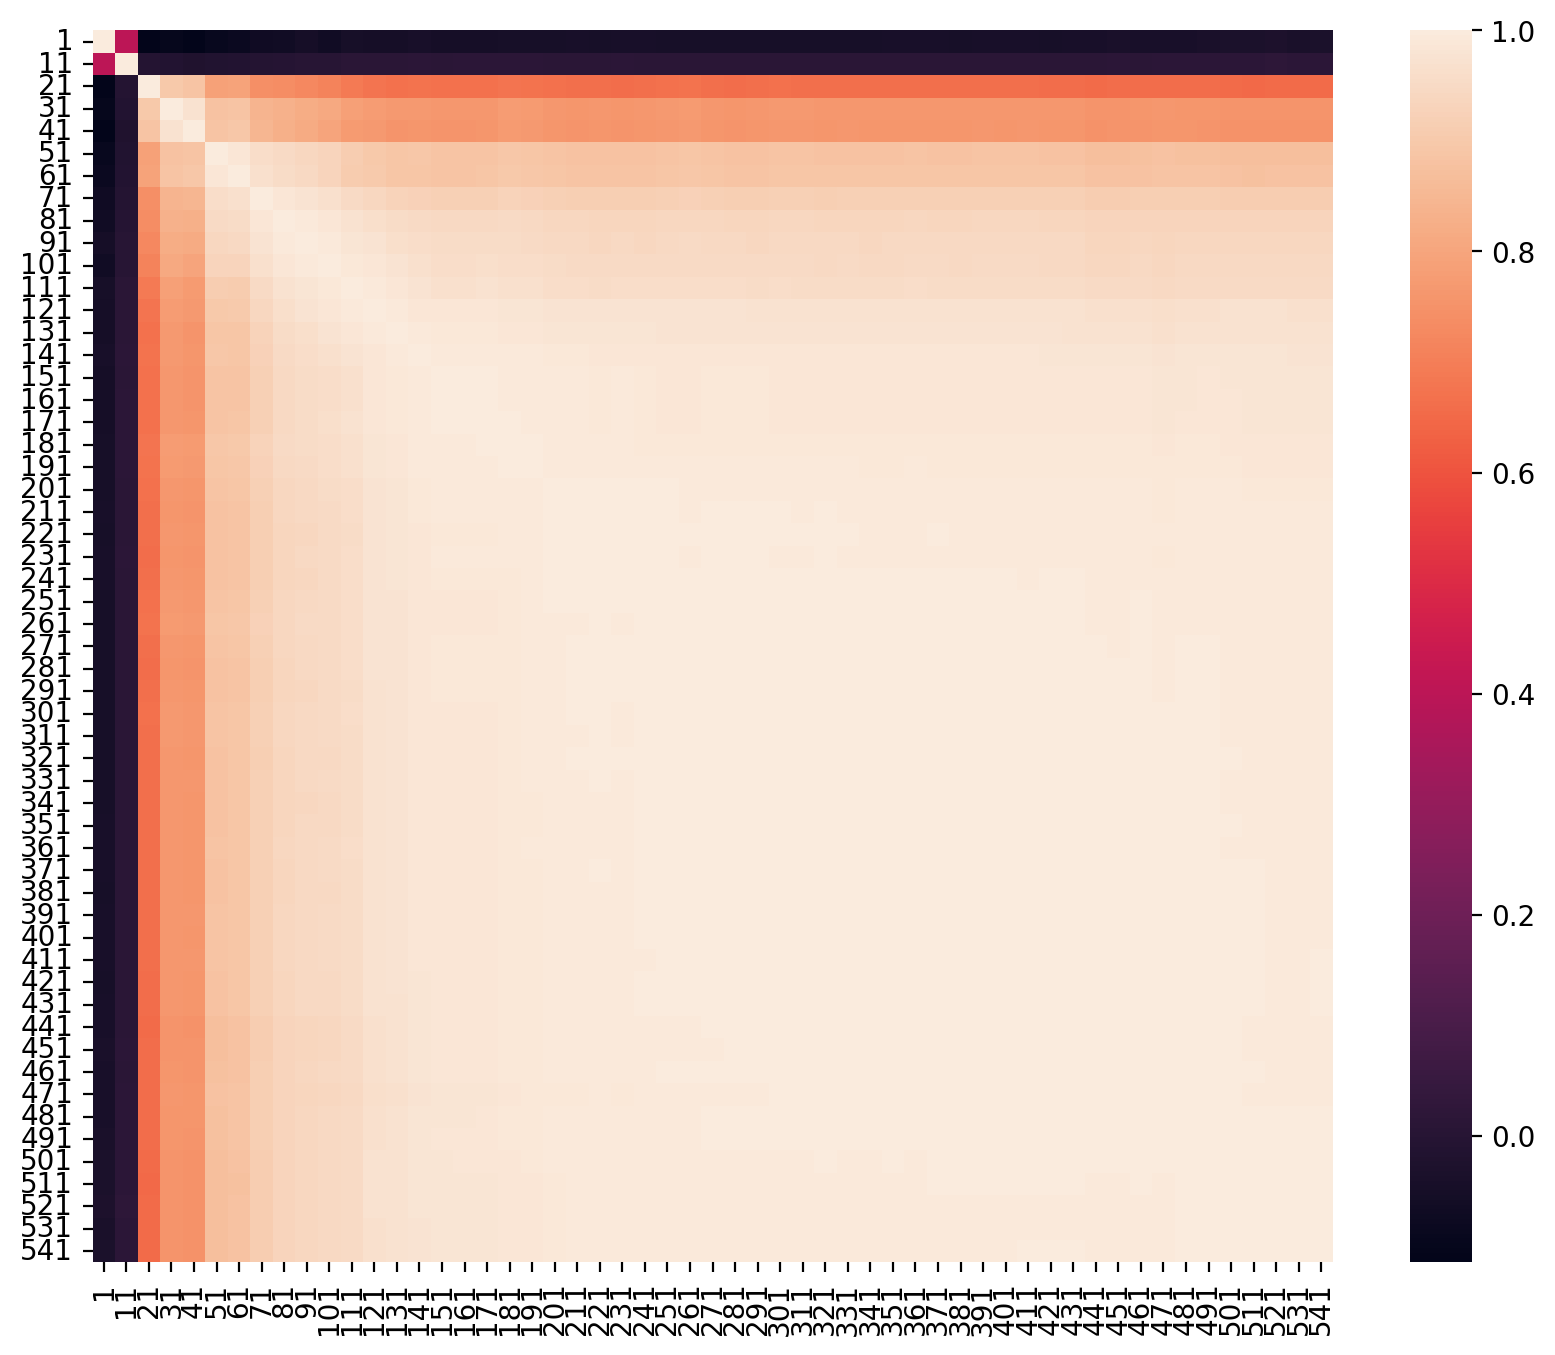

In [268]:
# mask = np.tril(np.ones(sims.shape)) + np.eye(len(sims))
plt.figure(figsize=(10, 8), dpi=200)
# sns.heatmap(corrs, annot=True)#, mask=mask)
sns.heatmap(corrs)
plt.xticks([i + 0.5 for i in range(len(corrs))], context_lengths, rotation=90)
plt.yticks([i + 0.5 for i in range(len(corrs))], context_lengths, rotation=0)
plt.show()

In [306]:
from sklearn.metrics.pairwise import cosine_similarity

corr_mats = []

for end in tqdm(range(100000, len(gb), 400000)):
    
    # context_lengths = [i for i in range(5000, 50000, 5000)]
    # context_lengths = [i for i in range(0, 510, 20)]
    context_lengths = [i for i in range(0, 10500, 500)]
    seqs = [str(gb[end - l - 1 : end].seq) for l in context_lengths]
    
    acts_list = []
    
    for s in (seqs):
        feats, acts = get_feature_ts(topk_sae, s)
        # info.append((feats, acts))
        acts_list.append(acts[0, -1, :])
        del feats
        del acts
        
    acts_list_stack = np.vstack(acts_list)
    
    # corrs = np.corrcoef(acts_list_stack)

    # corr_mats.append(corrs)
    cosine_sim = cosine_similarity(acts_list_stack)
    corr_mats.append(cosine_sim)

  0%|          | 0/12 [00:00<?, ?it/s]

In [307]:
stacked = np.vstack(acts_list)
stacked.shape

(21, 4096)

In [296]:
stacked_mean_subtracted = stacked - np.mean(stacked, axis = 0)

In [297]:
# np.mean(stacked, axis = 0).shape

In [298]:
# lasts = [i[1][0, -1, :] for i in info]
lasts = acts_list
len(lasts)

26

/datasets/evo2/tmp_env_share/evo2/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


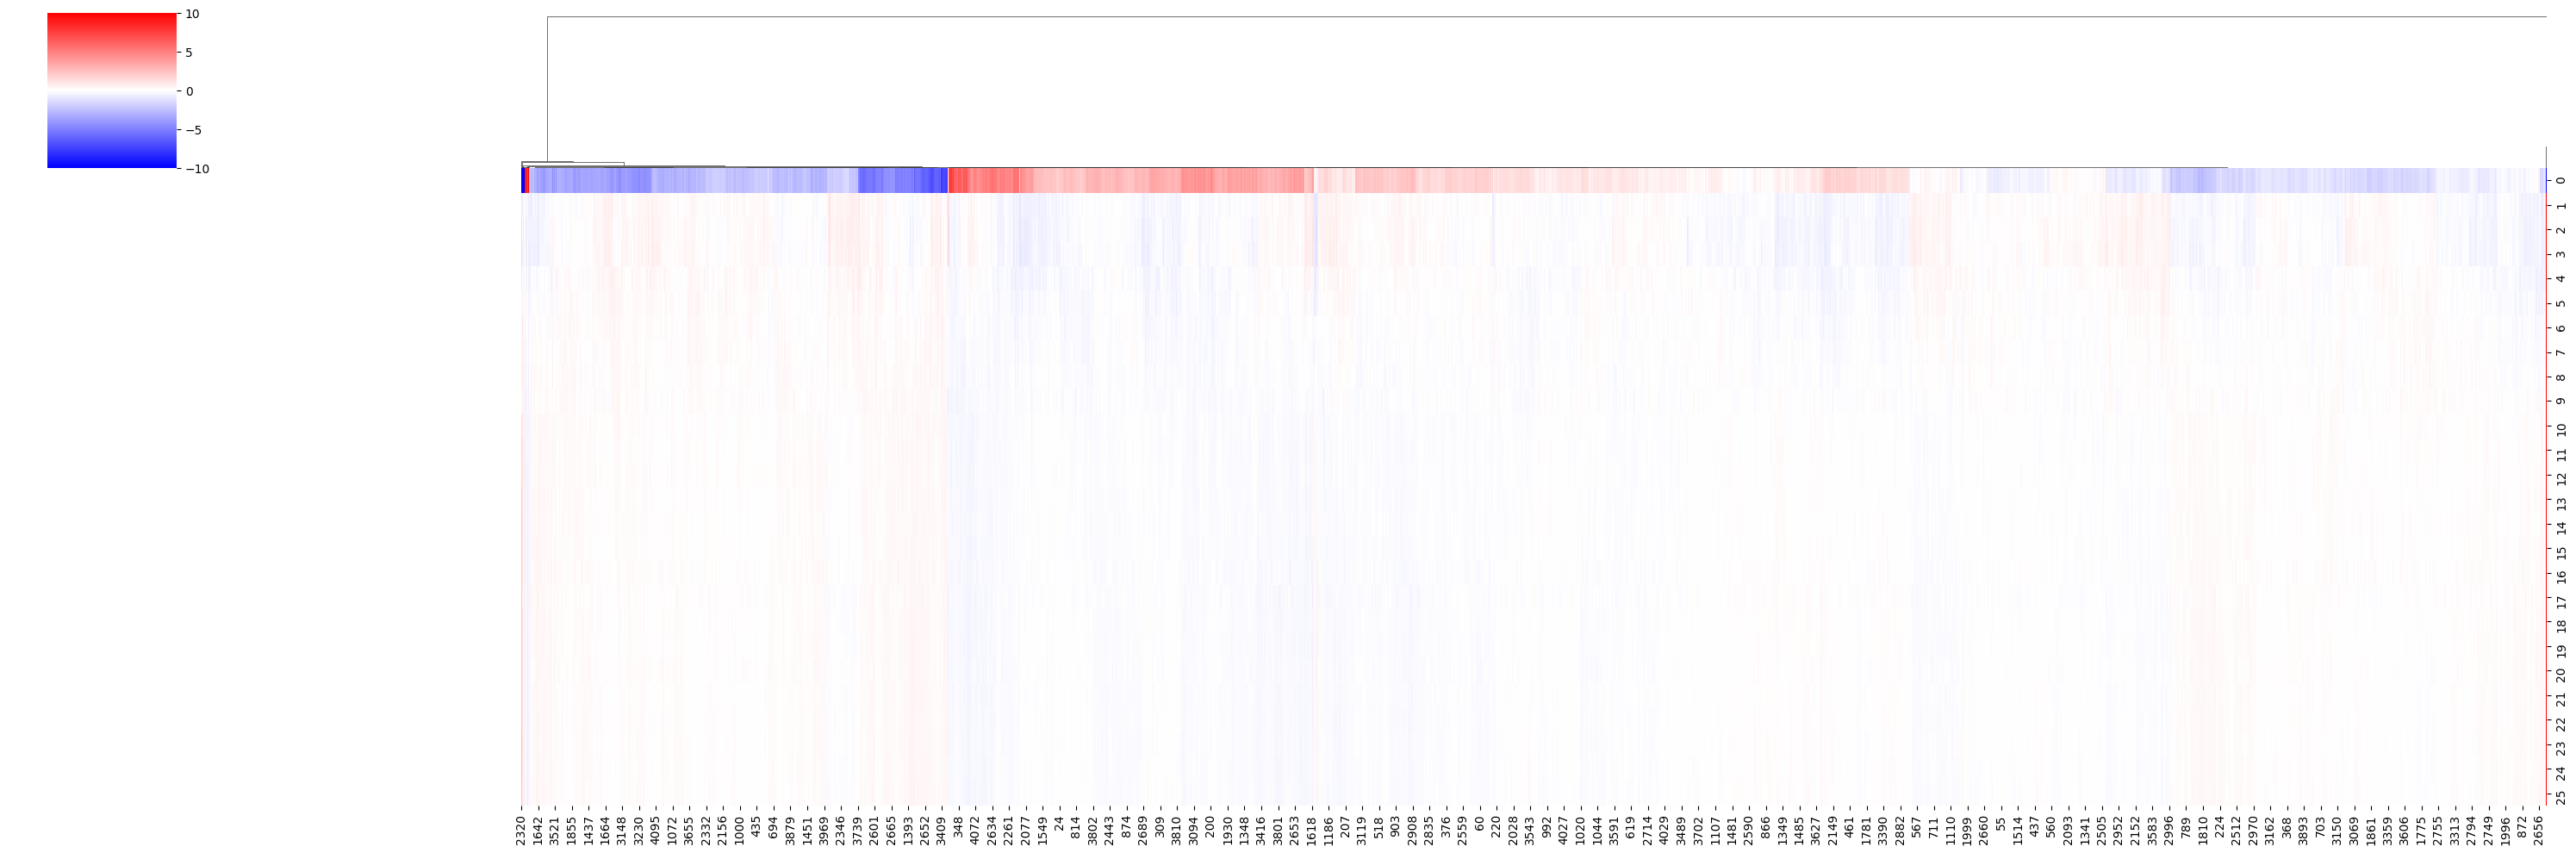

/datasets/evo2/tmp_env_share/evo2/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


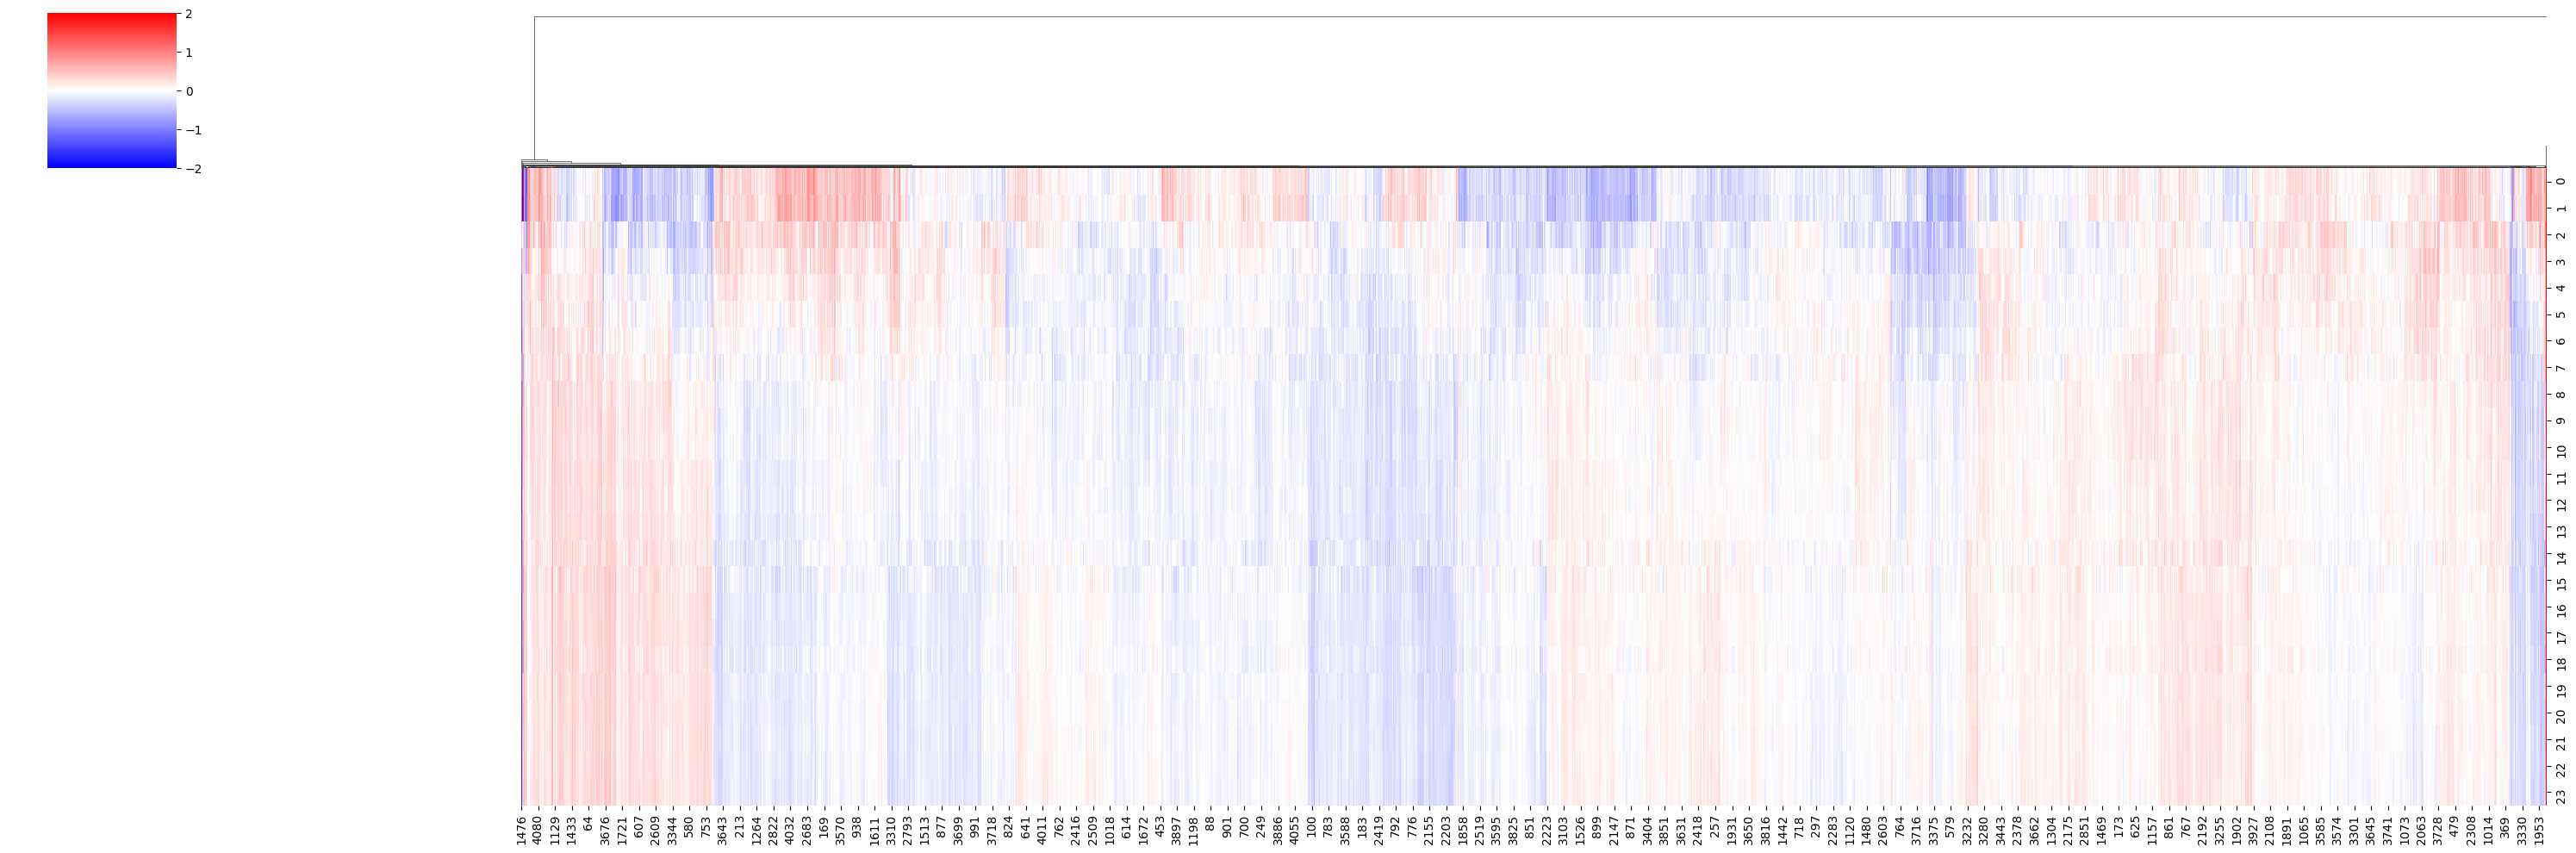

In [299]:
sns.clustermap(stacked_mean_subtracted, row_cluster=False, figsize = (30, 10), vmin=-10, vmax=10, cmap='bwr')
plt.show()
sns.clustermap(stacked_mean_subtracted[2:, :], row_cluster=False, figsize = (30, 10), vmin=-2, vmax=2, cmap='bwr')

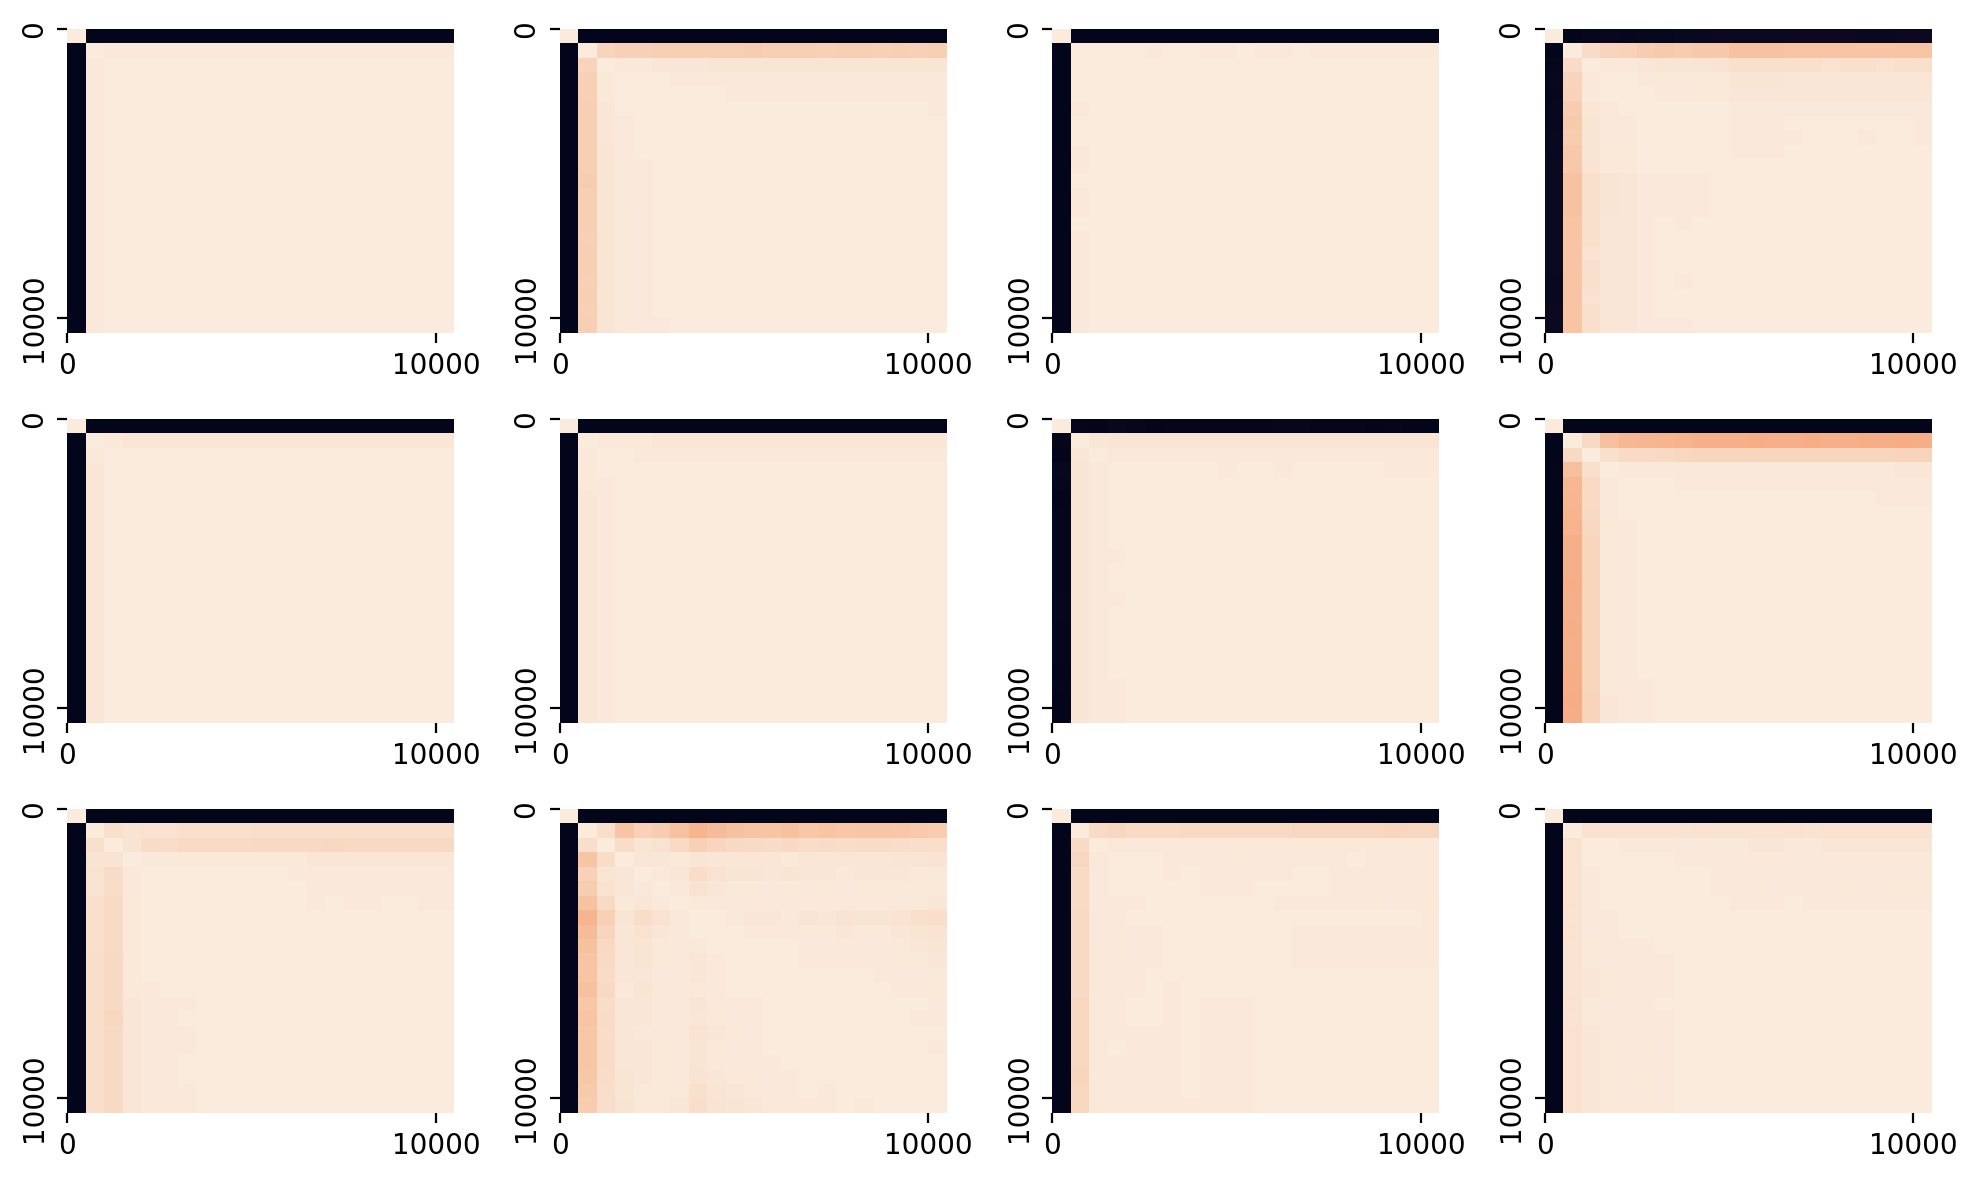

In [308]:
figs, axs = plt.subplots(nrows=3, ncols=4, figsize=(10, 6), dpi=200)
for i, corr in enumerate(corr_mats):
    ax = axs[i // 4, i % 4]
    sns.heatmap(corr, ax=ax, cbar=False, vmin=0, vmax=1)
    # to_plot_indices = range(0, 50, 10)
    ax.set_xticks([0, len(context_lengths) - 1], [context_lengths[0], context_lengths[-1]], rotation=0)
    ax.set_yticks([0, len(context_lengths) - 1], [context_lengths[0], context_lengths[-1]])
plt.tight_layout()
plt.show()

In [309]:
last_rows = [c[-1, :] for c in corr_mats]
last_rows = np.vstack(last_rows)
last_rows.shape

(12, 21)

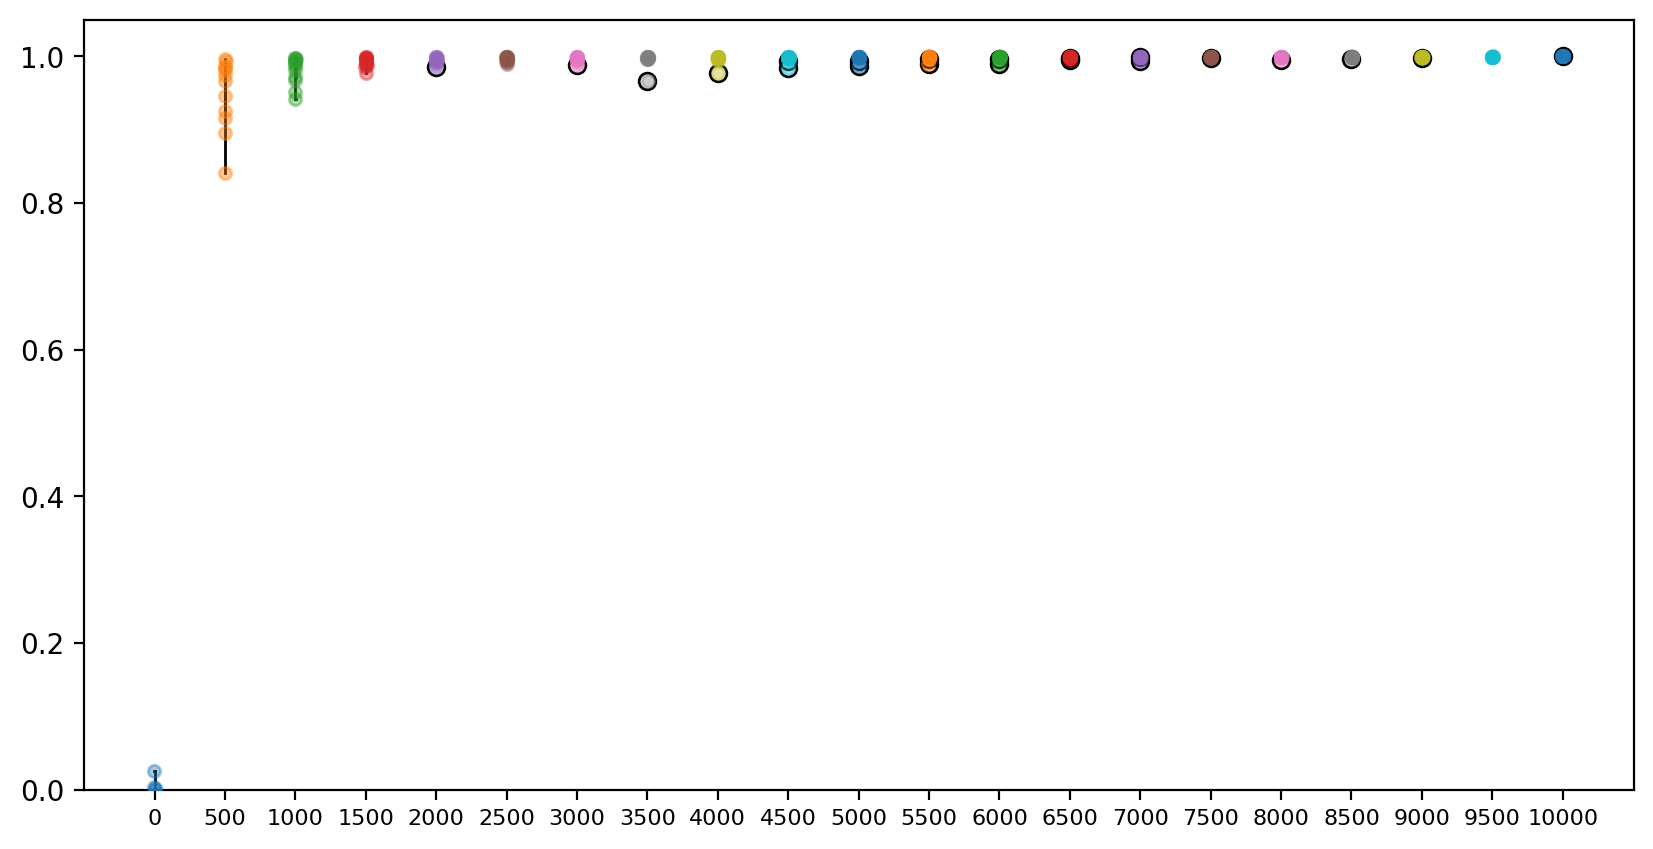

In [310]:
plt.figure(figsize=(10, 5), dpi=200)

for i, l in enumerate(context_lengths):
    plt.boxplot([last_rows[:, i]], positions=[l], widths=5)
    # pass

    # Stripplot - add jittered points
    y_values = last_rows[:, i]
    x_values = np.full(len(y_values), l)
    # Add jitter to x-axis for visibility
    x_jitter = x_values + np.random.normal(0, 2, size=len(x_values))
    plt.scatter(x_jitter, y_values, alpha=0.4, s=20, zorder=3)

# plt.xlim(0, 11000)

tick_indices = range(0, len(context_lengths), 2)  # Show every 2nd tick
# plt.xticks([context_lengths[i] for i in tick_indices], fontsize=5)
plt.ylim(0, 1.05)
plt.xticks(fontsize=8)

plt.show()